In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Euclidean Neural Networks

This activity is adapted from the [E3NN example](https://github.com/e3nn/e3nn-jax/blob/main/examples/tetris_point.py)

We will show the usage of Euclidean Neural Networks (E3NN) for predicting the shape of tetris pieces. But we are engineers so let's do it in $\mathbb{R^3}$. As you may know, a tetris piece is composed of four blocks, and each block is represented by a point in 3D space. These pieces can be rotated and translated by the user to fit in the desired space. We want to be able to predict the shape of the tetris piece no matter how it is rotated or translated. This can be done through the use of E3NNs, which are equivariant neural networks that are invariant to rotations, reflections and translations. Let's go ahead and install the required libraries.

In [45]:
# Currently e3nn breaks with jax 0.4.34, issue is raised
# pip install jax==0.4.33 flax jraph optax e3nn_jax kaleido plotly

In [46]:
import time
import flax
import jax
import jax.random as jr
import jax.numpy as jnp
import jraph
import optax
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import e3nn_jax as e3nn

First we need to think about how to represent our tetris pieces. So each tetris piece is four blocks, so four points in 3D space. We can represent each tetris piece as a 4x3 matrix, where each row represents the x, y, z coordinates of a block. Lets go ahead and define them.

In [47]:
# Define block positions for the different shapes
pos = jnp.array([
    [[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0]],  # chiral_shape_1
    [[1, 1, 1], [1, 1, 2], [2, 1, 1], [2, 0, 1]],  # chiral_shape_2
    [[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]],  # square
    [[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3]],  # line
    [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]],  # corner
    [[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 0]],  # L
    [[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1]],  # T
    [[0, 0, 0], [1, 0, 0], [1, 1, 0], [2, 1, 0]],  # zigzag
], dtype=jnp.float32)

# Define the labels for the different shapes
labels = jnp.arange(8)

# Create a dictionary with the labels to each shape name
shape_names = {
    0: "chiral_shape_1",
    1: "chiral_shape_2",
    2: "square",
    3: "line",
    4: "corner",
    5: "L",
    6: "T",
    7: "zigzag",
}

Now, most of us did not play Tetris in 3D, so let's visualize these pieces. We don't want just the block positions but also the connection between them. We can do this by connecting the blocks with lines. Let's go ahead plot the tetris pieces.

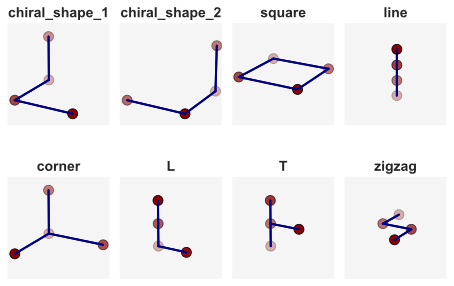

In [48]:
# Compute edges based on proximity
def compute_edges(p, radius=1.1):
    """Compute edges between nodes within a given radius."""
    senders = []
    receivers = []
    num_nodes = p.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = jnp.linalg.norm(p[i] - p[j])
                if distance <= radius:
                    senders.append(i)
                    receivers.append(j)
    return senders, receivers

# Lets make a helper function to plot the shapes
def plot_shapes(pos, names):
    """
    Plot the different shapes in 3D.

    Parameters:
    - pos: a JAX array of shape [num_shapes, num_nodes, 3], positions of nodes
    - shape_names: a dictionary mapping from index to shape name
    """
    fig = plt.figure(facecolor='white')

    for idx, p in enumerate(pos):
        # Compute edges based on proximity
        senders, receivers = compute_edges(p, radius=1.1)

        ax = fig.add_subplot(2, 4, idx + 1, projection='3d', facecolor='whitesmoke')
        ax.set_title(f"{names.get(idx, 'Shape ' + str(idx+1))}", fontsize=14, fontweight='bold')
        ax.set_axis_off()

        # Plot nodes
        x, y, z = p[:, 0], p[:, 1], p[:, 2]
        ax.scatter(x, y, z, c='darkred', s=100, edgecolors='black', depthshade=True)

        # Plot edges
        for sender, receiver in zip(senders, receivers):
            x_coords = [p[sender][0], p[receiver][0]]
            y_coords = [p[sender][1], p[receiver][1]]
            z_coords = [p[sender][2], p[receiver][2]]
            ax.plot(x_coords, y_coords, z_coords, c='navy', linewidth=2)

        # Set equal aspect ratio
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        z_range = z.max() - z.min()
        max_range = jnp.array([x_range, y_range, z_range]).max() / 2.0
        mid_x = (x.max() + x.min()) * 0.5
        mid_y = (y.max() + y.min()) * 0.5
        mid_z = (z.max() + z.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Adjust viewing angle
        ax.view_init(elev=20, azim=30)

    plt.tight_layout()
    plt.show()

# Plot the shapes
plot_shapes(pos, shape_names)



Great, so now you can see our tetris pieces. I think you can probably identify the shape of a piece even if it has been transformed. Lets transform a piece and plot it to see if you can still identify the shape.

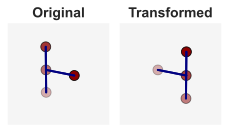

In [49]:
# Define a transformation matrix
transformation = jnp.array([[1, 0, 0], 
                            [0,  -1, 0], 
                            [0,  0, 1]], dtype=jnp.float32)

# Apply the transformation to the positions
T_transformed = jnp.einsum("ij,nj->ni", transformation, pos[6])

names = {0: "Original", 1: "Transformed"}

# Plot the shapes
plot_shapes(jnp.stack([pos[6], T_transformed]), names)

I picked an easy transformation to see, just a reflection across the y axis.
Play around with the transformation and see if you can still identify the shape of the piece, try rotating it or translating it. Though a translation may be hard to see since we are only plotting the points.

Your brain probably can recognize the shape of the piece no matter how it is tranformed. We want to build a neural network that can do the same. 
The first thing that we have to do is give our network data that it can understand. We will turn the tetris pieces into a graph. We will use [jraph](https://jraph.readthedocs.io/en/latest/index.html), a jax library for graph neural networks. We will represent each block as a node in the graph and the connections between the blocks as edges. We will also add a global node to the graph to represent the whole piece. Let's go ahead and do that.

In [50]:
# Create a function to create the graphs
def create_tetrisGraphs(positions: jax.Array, 
                        labels: jax.Array
                        ) -> jraph.GraphsTuple:
    
    # Initialize an empty list to store the graphs
    graphs = []

    # Loop over each shape and create a graph for each
    for p, l in zip(positions, labels):

        # Precompute edges based on proximity
        senders, receivers = e3nn.radius_graph(p, 1.1)

        # Use jraph to create a graph
        graphs += [
            jraph.GraphsTuple(
                nodes=p.reshape((4, 3)),  # [num_nodes, 3]
                edges=None,
                globals=l[None],  # [num_graphs]
                senders=senders,  # [num_edges]
                receivers=receivers,  # [num_edges]
                n_node=jnp.array([len(p)]),  # [num_graphs]
                n_edge=jnp.array([len(senders)]),  # [num_graphs]
            )
        ]

    # Return the batched graphs
    return jraph.batch(graphs)

# Create the dataset
graphs = create_tetrisGraphs(pos, labels)

Now comes the complicated part. A fair bit of math is involved in E3NNs. At a high level they are using geometric tensor algebra to form equivariant convolutional kernels. So this continuous convolutional filter is defined as:

$$
W(\overrightarrow{r}) = R(r)Y_l^m(\hat{r})
$$

where $R(r)$ is a learned radial function, $Y_l^m(\hat{r})$ representes spherical harmonics. Spherical harmonics are a set of functions that form an orthonormal basis over the surface of a sphere. You may remember them from their usage in atomic orbitals.

But to put it more simply, the Euclidean neural network operates in terms of geometry. It converts geometry into features by projecting onto these sphereican harmonics. These geometric tensors are just saying that it categorizes the data based on how it transforms with respect to rotations, reflections, and translations. This is what makes it equivariant.

Let's play around with the spherical harmonics to see how they look. They call these irreducible representations or "irreps". 

Change the value of ``ell`` to see the different harmonics. Here we think about even and odd functions and how these transform under parity. You will put ``e`` for even and ``o`` for odd. 

- ``ell = 0e`` is a constant function (a scalar, does not change under parity)
- ``ell = 1o`` is a vector (changes sign under parity)
- ``ell = 1e`` is a pseudo-vector (does not change under parity)
- ``ell = 2e`` is a double-headed ray (does not change under parity)
- ``ell = 2o`` is a helix (changes sign under parity)

Beyond these, the higher the value of ``ell`` the more complex the function. Go ahead and play around with the values to see how they look.


In [51]:
ell = "1e"

In [52]:
def get_cmap(x):
    if x == "bwr":
        return [[0, "rgb(0,50,255)"], [0.5, "rgb(200,200,200)"], [1, "rgb(255,50,0)"]]
    if x == "plasma":
        return [
            [0, "#9F1A9B"],
            [0.25, "#0D1286"],
            [0.5, "#000000"],
            [0.75, "#F58C45"],
            [1, "#F0F524"],
        ]


alpha = jnp.linspace(0, 2 * jnp.pi, 200)
beta = jnp.linspace(0, jnp.pi, 200)

alpha, beta = jnp.meshgrid(alpha, beta, indexing="ij")
vectors = e3nn.angles_to_xyz(alpha, beta)

signal = e3nn.spherical_harmonics(
    ell, vectors, normalize=True, normalization="component"
).array
signal = signal[:, :, 8]

data = [
    go.Surface(
        x=jnp.abs(signal) * vectors[:, :, 0],
        y=jnp.abs(signal) * vectors[:, :, 1],
        z=jnp.abs(signal) * vectors[:, :, 2],
        surfacecolor=signal,
        showscale=False,
        cmin=-1.5,
        cmax=1.5,
        colorscale=get_cmap("bwr"),
    )
]

axis = dict(
    showbackground=False,
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    title="",
    nticks=3,
    range=[-3, 3],
)

layout = dict(
    width=512,
    height=512,
    scene=dict(
        xaxis=dict(**axis),
        yaxis=dict(**axis),
        zaxis=dict(**axis),
        aspectmode="manual",
        aspectratio=dict(x=4, y=4, z=4),
        camera=dict(
            up=dict(x=0, y=1, z=0),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=0, z=5),
            projection=dict(type="orthographic"),
        ),
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=0, r=0, t=0, b=0),
)

fig = go.Figure(data=data, layout=layout)
fig.show()

Now lets take a look at some of the algebra that we can do with these irreps. We can take the tensor product of two irreps to get a new irrep. Let's go ahead and do that.

In [53]:
irrep1 = e3nn.Irreps("1e")
irrep2 = e3nn.Irreps("2o")

tp = e3nn.tensor_product(irrep1, irrep2)
print(tp)

1x1o+1x2o+1x3o


See how the new irrep contains the information of the two original irreps. We can also just create a string of irreps added together.

In [54]:
irrep3 = e3nn.Irreps("1e + 2o + 3o")
print(irrep3)

1x1e+1x2o+1x3o


Okay, this is all great but how do we use this in our neural network? We can use these irreps as the basis for our network. But we have to learn which of these irreps are important for our data. We can do this by using a neural network to learn weights for each irrep. Let me show you how we can do this.

In [55]:
# Define a linear layer
layer = e3nn.flax.Linear(irrep3)

# Randomly initialize non-zero weights for two of the irreps
x = e3nn.normal("2o + 3o", jr.PRNGKey(0))
w = layer.init(jr.PRNGKey(0), x)

# Apply the layer to the input
y = layer.apply(w, x)
print(y.irreps)

1x2o+1x3o


Notice how the output of this linear layer no longer has our first irrep, ``1e``. So we what this network has "learned" is that the first irrep is not important for our data. Now that we have these weights, we can learn them through backpropagation. This is how we can build a neural network that is equivariant to rotations, reflections, and translations. 

Let's get back to our tetris problem.
We're going to limit ourselves to just the few spherical harmonics.  

If you are interested you can read more about [E3NN](https://e3nn.org/). We are using models built on top of the neural network library [Flax](https://flax-linen.readthedocs.io/en/latest/). First we define a single layer of the network. We will use this to build a deeper network. There's a lot going on here with the graph neural network (edges, senders, receivers, globals), but focus on the spherical harmonics and the linear layers.

In [56]:
class Layer(flax.linen.Module):
    target_irreps: e3nn.Irreps
    denominator: float
    # The maximum degree of the spherical harmonics
    sh_lmax: int = 3

    @flax.linen.compact
    def __call__(self, graphs, positions):
        # Define the target irreps
        target_irreps = e3nn.Irreps(self.target_irreps)

        def update_edge_fn(edge_features, sender_features, receiver_features, globals):
            # Compute the spherical harmonics for up to sh_lmax
            sh = e3nn.spherical_harmonics(
                list(range(1, self.sh_lmax + 1)),
                positions[graphs.receivers] - positions[graphs.senders],
                True,
            )
            # Perform tensor product with the sender features
            return e3nn.concatenate(
                [sender_features, e3nn.tensor_product(sender_features, sh)]
            ).regroup()

        def update_node_fn(node_features, sender_features, receiver_features, globals):
            # Scale the receiver features
            node_feats = receiver_features / self.denominator
            # Apply a linear layer to the node features
            node_feats = e3nn.flax.Linear(target_irreps, name="linear_pre")(node_feats)
            # Apply an activation function to introduce non-linearity
            node_feats = e3nn.scalar_activation(node_feats)
            # Apply another linear layer to the node features
            node_feats = e3nn.flax.Linear(target_irreps, name="linear_post")(node_feats)
            shortcut = e3nn.flax.Linear(
                node_feats.irreps, name="shortcut", force_irreps_out=True
            )(node_features)
            return shortcut + node_feats

        # Apply the update functions to the Graph Network
        return jraph.GraphNetwork(update_edge_fn, update_node_fn)(graphs)

Okay, the worst is over. Now lets create the network. First what you can see is that our graph nodes, or locations of individual blocks in the tetris shapes are being turned into vectors, irreps of ``1o``. These vectors are then put into the graph structure.

There are 4 hidden layers in the network. The first three are identical. They are given as ``"32x0e + 32x0o + 8x1e + 8x1o + 8x2e + 8x2o"`` which are the irreps that operate with our graph in the network, similar to irrep1 and irrep2 in our small example. The last layer is the output layer. The scatter sum then takes the node features and places them into a single tensor. Then we have the usual classification logits, which feed into the softmax to give us our prediction class.


In [57]:
class Model(flax.linen.Module):
    @flax.linen.compact
    def __call__(self, graphs):
        positions = e3nn.IrrepsArray("1o", graphs.nodes)
        graphs = graphs._replace(nodes=jnp.ones((len(positions), 1)))

        layers = 3 * ["32x0e + 32x0o + 8x1e + 8x1o + 8x2e + 8x2o"] + ["0o + 7x0e"]

        for irreps in layers:
            graphs = Layer(irreps, 1.5)(graphs, positions)

        # Readout logits
        pred = e3nn.scatter_sum(
            graphs.nodes.array, nel=graphs.n_node
        )  # [num_graphs, 1 + 7]
        odd, even1, even2 = pred[:, :1], pred[:, 1:2], pred[:, 2:]
        logits = jnp.concatenate([odd * even1, -odd * even1, even2], axis=1)
        assert logits.shape == (len(graphs.n_node), 8)  # [num_graphs, num_classes]

        return logits

Okay so now we have the model, let's train it on the dataset we created earlier. This should part should look similar to the other neural networks we have trained in JAX. As a reminder we are performing a classification task, so we are using a softmax to give us a labeled output class.

In [58]:
# Model initialization
model = Model()

# Optimizer initialization
opt = optax.adam(learning_rate=0.01)

# Define the classification loss function
def loss_fn(params, graphs):
    logits = model.apply(params, graphs)
    labels = graphs.globals  # [num_graphs]

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    loss = jnp.mean(loss)
    return loss, logits

# Define the update step
@jax.jit
def update_fn(params, opt_state, graphs):
    grad_fn = jax.grad(loss_fn, has_aux=True)
    grads, logits = grad_fn(params, graphs)
    labels = graphs.globals
    accuracy = jnp.mean(jnp.argmax(logits, axis=1) == labels)

    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, accuracy

# Initiation
init = jax.jit(model.init)
params = init(jax.random.PRNGKey(3), graphs)
opt_state = opt.init(params)

# Training Loop
steps = 100
print_freq = 5
wall = time.perf_counter()
print("training...", flush=True)

for i in range(steps):
    params, opt_state, accuracy = update_fn(params, opt_state, graphs)

    if i % print_freq == 0:
        print(f"step {i}: accuracy = {100 * accuracy:.2f}%", flush=True)

    if accuracy == 1.0:
        print(f"early stopping at step {i}")
        break

print(f"final accuracy = {100 * accuracy:.0f}%")

training...
step 0: accuracy = 12.50%
step 5: accuracy = 50.00%
step 10: accuracy = 62.50%
step 15: accuracy = 87.50%
early stopping at step 19
final accuracy = 100%


Okay great, it thinks it has learned the shape of the tetris pieces. Let's see if it can predict the shape of a piece in a different orientation.

I will make you a function to create a new graph from your transformed piece. Then it will predict which shape it is along with the true shape.

In [59]:
def test_transform(transformed_shape, shape_idx):

    # Create a new graph with the transformed shape
    senders, receivers = e3nn.radius_graph(transformed_shape, 1.1)
    transformed_graph = jraph.GraphsTuple(
        nodes=transformed_shape.reshape((4, 3)),
        edges=None,
        globals=jnp.array([5]),  # The label for the L shape is 5
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([4]),
        n_edge=jnp.array([len(senders)]),
    )

    # Batch the graph
    transformed_graph = jraph.batch([transformed_graph])

    # Predict the class of the rotated shape
    logits = model.apply(params, transformed_graph)
    predicted_class = jnp.argmax(logits, axis=1)

    print(f"Predicted class for the transformed shape: {predicted_class[0]}")
    print(f"True class for the transformed shape: {shape_idx}")

Shape: chiral_shape_2


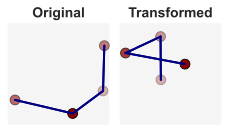

Predicted class for the transformed shape: 1
True class for the transformed shape: 1


In [64]:
# Pick the shape and print the name
shape_idx = 1
print(f"Shape: {shape_names[shape_idx]}")

# Define the rotation matrix
rotation = jnp.array([[0, -1, 0], 
                      [1, 0, 0], 
                      [0, 0, 1]], dtype=jnp.float32)

# Define the translation vector
translation = jnp.array([2, -1, 3], dtype=jnp.float32)

original_shape = pos[shape_idx]
rotated = jnp.einsum("ij,nj->ni", rotation, original_shape)
translated = rotated + translation

# Plot the shapes
plot_shapes(jnp.stack([pos[shape_idx], translated]), 
            {0: "Original", 1: "Transformed"})

# Test the transformation
test_transform(translated, shape_idx)

Wow! It predicted the shape of the piece even though it was rotated 90 degrees. and translated somewhere else in space. And it was only trained on one example of each piece! This is the power of equivariant neural networks. 

Now go ahead and try the different shapes and apply different transformations, maybe a reflection or rotation around another axis to see if the model can still predict the correct shape.

Playing tetris is a definitely a lot of fun, but having networks that can learn geometry with less data is very powerful. See the creators of E3NN use it as a [surrongate for molecular dynamics simulations](https://www.nature.com/articles/s41467-022-29939-5)